<a href="https://colab.research.google.com/github/Knightzjz/NCL-IML/blob/main/NCL_IML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Pre-training-free Image Manipulation Localization through Non-Mutually Contrastive Learning (ICCV2023)**

Jizhe Zhou, Xiaochen Ma, Xia Du, Ahemd Y.Alhammadi, Wentao Feng* \\
<font face="Microsoft YaHei" size=2> Sichuan University &  Xiamen University of Technology & Mohamed Bin Zayed University for Humanities </font> \\
<font  size=2>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</font> \\
<font  size=4 color=blue>This colab contains the demo in our paper and creats a playground allowing you to test NCL model with your customized input. If you feel helpful, please cite our work. :D</font> \\

<font  size=2>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</font> \\
<mark><font size=4 color=blue> Playing Tips:</mark></font> \\

1.<font face="黑体" size=4 color=grey> Due to Google Cloud Disk reasons, the "Preparation" section may not be running. But it WON'T break this notebook; just ignore it and execute the rest sections in sequence.</font> \\

2.<font face="黑体" size=4 color=grey> The loaded CaCL-Net is the NCL model proposed in our paper.  The nickname "CaCL-Net" comes from a local Macau restaurant called "CaCL", where we came up with the NCL idea. </font> \\

3.<font face="黑体" size=4 color=grey> The 4th "Result Display" section shows some representative results of NCL on those frequently-compared images. Scrolling down the right slide in this section to view all pictures. Random selection from the pic pool will be involving soon, stay tuned.</font> \\

4.<font face="黑体" size=4 color=grey> We build a small playground in the 5th "Test Samples From Web" section. Substituting the default image URLs stored in "urls=[...]" with your own ones and then re-execute this section, you will get the results of TCL on your customized input! Hope you will enjoy it and please contact us if any exception occurs.</font> \\

<font  size=2>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</font> \\


## **Preparation**

In [ ]:
import shutil
shutil.rmtree("SampleData")

## **1. Environment Configuration**

In [ ]:
!gdown https://drive.google.com/uc?id=13G-Ay5Sx7o2jpG_AdjVA2drpFXZ0R2kJ
!unzip CaCLNet.zip
Sample_path = 'SampleData'

!gdown https://drive.google.com/uc?id=1urqD-AqGiHSB8k3ruz2HJuu-mBxWqqf0
CaCLNet_path = '20230319-010.pth'

!rm CaCLNet.zip

Downloading...
From: https://drive.google.com/uc?id=13G-Ay5Sx7o2jpG_AdjVA2drpFXZ0R2kJ
To: /content/CaCLNet.zip
100% 19.6M/19.6M [00:00<00:00, 122MB/s]
Archive:  CaCLNet.zip
   creating: SampleData/
  inflating: SampleData/NC2016_0048.jpg  
  inflating: SampleData/NC2016_0211.jpg  
  inflating: SampleData/NC2016_0343.jpg  
  inflating: SampleData/NC2016_0444.jpg  
  inflating: SampleData/NC2016_0741.jpg  
  inflating: SampleData/NC2016_4274.jpg  
  inflating: SampleData/NC2016_6796.jpg  
replace custom_transforms.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: custom_transforms.py    
  inflating: utils.py                
  inflating: modeling/aspp.py        
  inflating: modeling/backbone/resnet.py  
  inflating: modeling/backbone/__init__.py  
  inflating: modeling/decoder.py     
  inflating: modeling/deeplab.py     
  inflating: modeling/sync_batchnorm/batchnorm.py  
  inflating: modeling/sync_batchnorm/comm.py  
  inflating: modeling/sync_batchnorm/replicate.py  
  inflati

## **2. Load Sample Dataset**

In [ ]:
import os
SampleList=[]
for file in os.listdir(Sample_path):
  name = os.path.join(Sample_path, file)
  SampleList.append(name)
print(SampleList)

['SampleData/NC2016_0444.jpg', 'SampleData/NC2016_6796.jpg', 'SampleData/NC2016_0048.jpg', 'SampleData/NC2016_0343.jpg', 'SampleData/NC2016_0211.jpg', 'SampleData/NC2016_4274.jpg', 'SampleData/NC2016_0741.jpg']


## **3. Load a Pre-trained CaCL-Net Model**

In [ ]:
import torch
CaCLNet = torch.load('/content/20210319-010.pth')


## **4. Result Display**

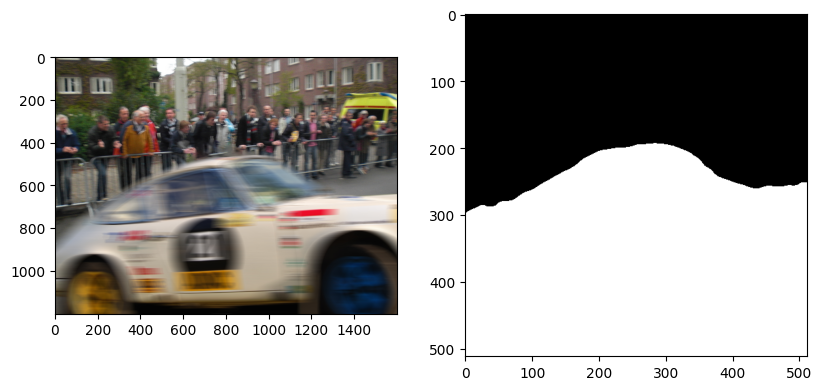

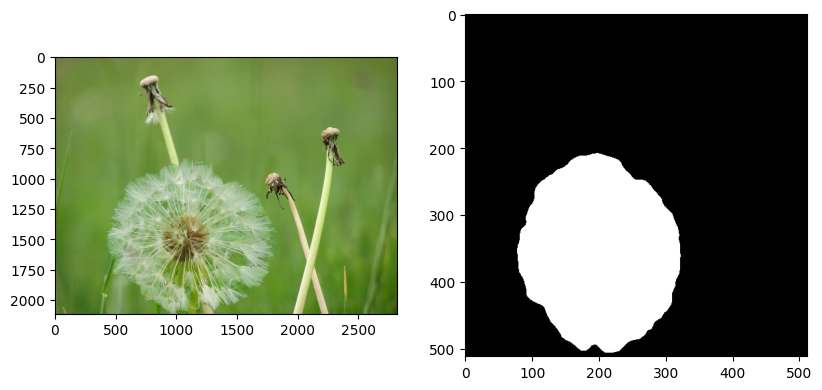

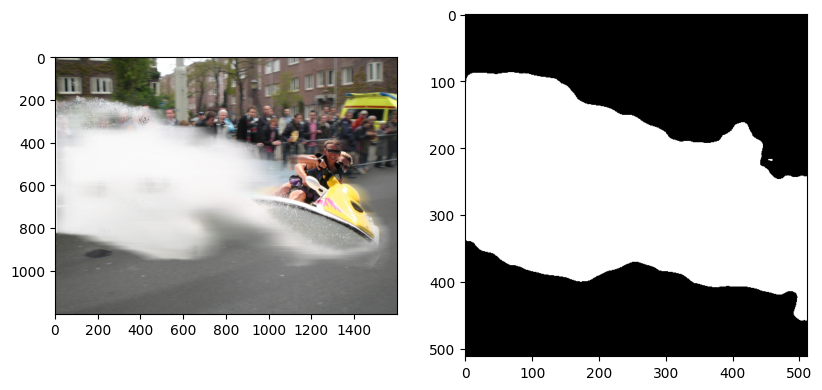

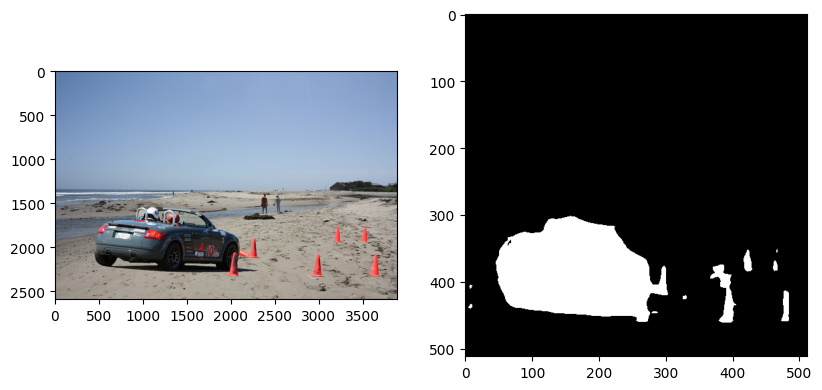

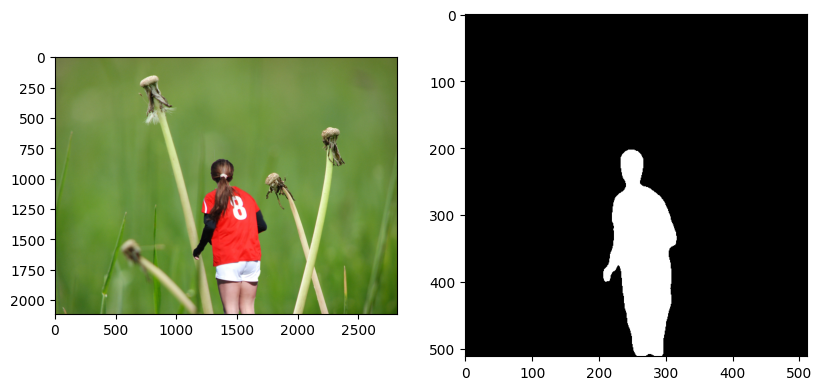

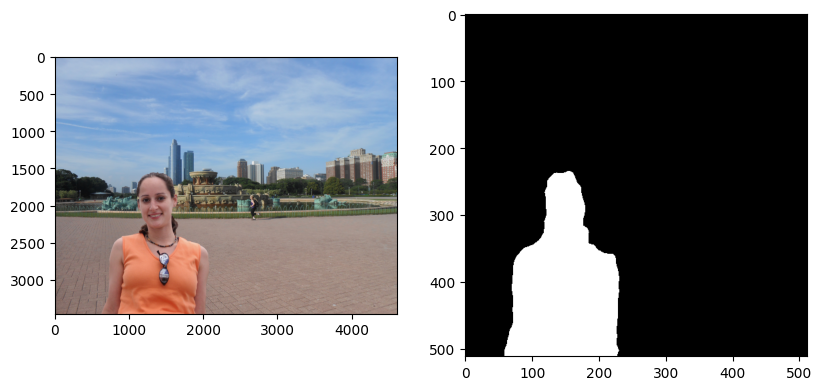

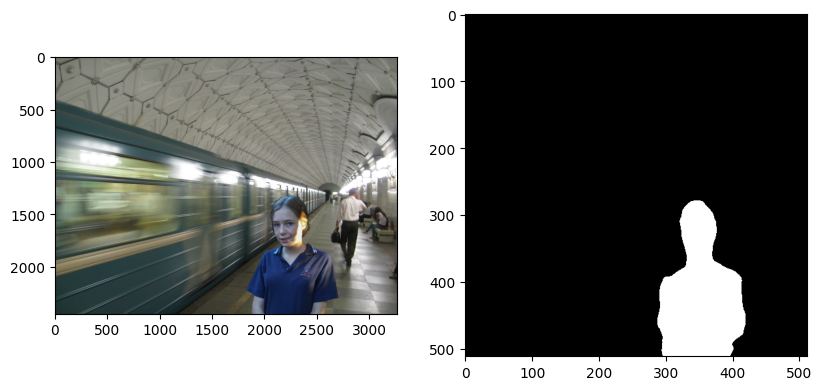

In [ ]:
import cv2
import custom_transforms as tr
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from utils import decode_seg_map_sequence
import torch
from matplotlib import pyplot


composed_transforms = transforms.Compose([
    tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    tr.ToTensor()])

for name in SampleList:
    im = cv2.imread(name)
    b, g, r = cv2.split(im)
    rgb = cv2.merge([r, g, b])
    image = Image.fromarray(rgb)
    image = image.resize((512, 512), Image.BILINEAR)

    target = 0.0  # Consistent with training process
    sample = {'image': image, 'label': target}

    tensor_in = composed_transforms(sample)['image'].unsqueeze(0)
    tensor_in = tensor_in.cuda()
    CaCLNet.eval()
    _, _, _, output = CaCLNet(tensor_in)
    grid_image = make_grid(decode_seg_map_sequence(torch.max(output[:3], 1)[1].detach().cpu().numpy()),
                               3, normalize=False, range=(0, 255))
    save_image(grid_image, "mask.png")
    img = cv2.imread("mask.png")
    pyplot.figure( figsize=(15,5) )
    pyplot.subplot(131)
    pyplot.imshow( rgb )
    pyplot.subplot(132)
    pyplot.imshow( img )


# **5. Test Samples From Web**

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np

def test_image_from_web():

  for url in urls:
    response = requests.get(url)
    rgb = np.asarray(Image.open(BytesIO(response.content)))  # pil->numpy->bgr
    image = Image.fromarray(rgb)
    image = image.resize((512, 512), Image.BILINEAR)

    target = 0.0  # Consistent with training process
    sample = {'image': image, 'label': target}
    tensor_in = composed_transforms(sample)['image'].unsqueeze(0)
    tensor_in = tensor_in.cuda()
    CaCLNet.eval()
    _, _, _, output = CaCLNet(tensor_in)
    grid_image = make_grid(decode_seg_map_sequence(torch.max(output[:3], 1)[1].detach().cpu().numpy()),
                               3, normalize=False, range=(0, 255))
    save_image(grid_image, "mask.png")
    img = cv2.imread("mask.png")
    pyplot.figure( figsize=(15,5) )
    pyplot.subplot(131)
    pyplot.imshow( rgb )
    pyplot.subplot(132)
    pyplot.imshow( img )




* Images from Internet
* you can replace the url with our own data for testing !

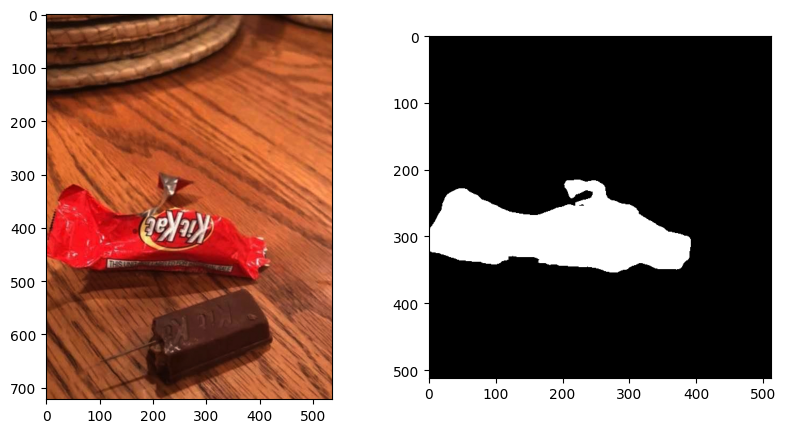

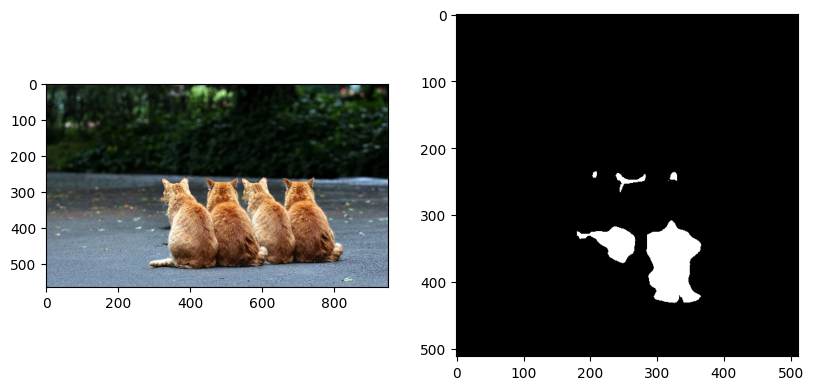

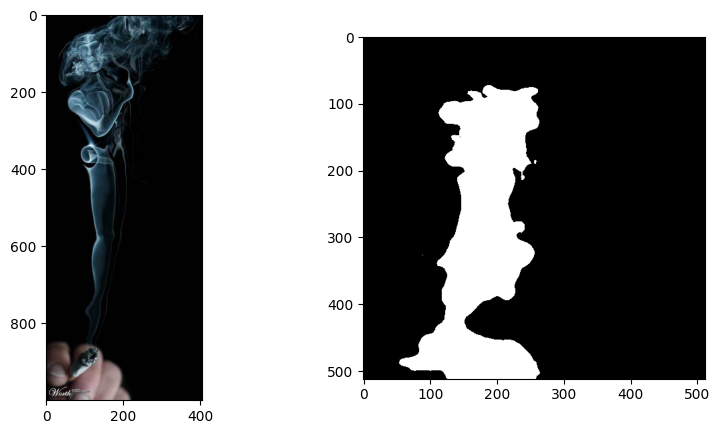

In [ ]:

urls = [
  'http://nadignewspapers.com/wp-content/uploads/2019/11/Kit-11.jpg',
  'https://www.digitalforensics.com/blog/wp-content/uploads/2016/09/digital_image_forgery_detection.jpg',
  'https://assets.hongkiat.com/uploads/amazing-photoshop-skills/topps20.jpg'
]

test_image_from_web()